# setup

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
import pandas as pd
import easydarkfigs
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [2]:
%set_darkfigdir figures_dark/
%set_lightfigdir figures/

In [3]:
%%time
from results import models, results, pcmds, data, radii_am, radii_kpc, dmods, regions
import results as rr

CPU times: user 20.8 ms, sys: 11.7 ms, total: 32.5 ms
Wall time: 50.2 ms


In [38]:
%%time
from drivers import filters, iso_models, drivers, sky

Loading Isochrone Models
CPU times: user 44.2 s, sys: 10.3 s, total: 54.4 s
Wall time: 55.5 s


GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.GPU acceleration not available. Continuing without.

In [16]:
%%time
for i in [8,9,10,11,12]:
    print(i)
    rr.load_model(i, all_quads=(i==9))

8
M87
M87v2
M49
NGC3377
NGC4993
M31 Bulge
M51
Skipping M51_a_m8
Skipping M51_b_m8
Skipping M51_c_m8
Skipping M51_d_m8
Skipping M51_e_m8
9
M87
Skipping M87_a2_m9
Skipping M87_a3_m9
Skipping M87_a4_m9
Skipping M87_b2_m9
Skipping M87_b3_m9
Skipping M87_b4_m9
Skipping M87_c2_m9
Skipping M87_c3_m9
Skipping M87_c4_m9
M87v2
M49
Skipping M49_a2_m9
Skipping M49_a3_m9
Skipping M49_a4_m9
Skipping M49_b2_m9
Skipping M49_b3_m9
Skipping M49_b4_m9
Skipping M49_c2_m9
Skipping M49_c3_m9
Skipping M49_c4_m9
NGC3377
Skipping NGC3377_a2_m9
Skipping NGC3377_a4_m9
Skipping NGC3377_b2_m9
Skipping NGC3377_b3_m9
Skipping NGC3377_b4_m9
Skipping NGC3377_c2_m9
Skipping NGC3377_c3_m9
Skipping NGC3377_c4_m9
NGC4993
Skipping NGC4993_a2_m9
Skipping NGC4993_a4_m9
Skipping NGC4993_b2_m9
Skipping NGC4993_b3_m9
Skipping NGC4993_b4_m9
Skipping NGC4993_c2_m9
Skipping NGC4993_c3_m9
Skipping NGC4993_c4_m9
M31 Bulge
M51
10
M87
M87v2
M49
NGC3377
NGC4993
M31 Bulge
M51
11
M87
M87v2
M49
NGC3377
NGC4993
M31 Bulge
M51
12
M87
M87v2
M

In [21]:
new_mlls = {}
for k in tqdm(list(pcmds.keys())):
    r = results[k]
    mll = float(r.max_logl)
    while (r.as_dynesty(max_logl=mll)['delta_logz'][-1] >= 1e-3):
        mll -= 10.
    new_mlls[k] = mll

100%|██████████| 115/115 [04:04<00:00,  2.13s/it]


In [22]:
old_mlls = {k: results[k].max_logl for k in new_mlls.keys()}

In [23]:
for k in tqdm(new_mlls.keys()):
    results[k].max_logl = new_mlls[k]

100%|██████████| 115/115 [00:16<00:00,  7.07it/s]


In [17]:
plt.style.use('cook')
colors = sns.color_palette('colorblind', 10)
markers = ['o', 's', 'D', '*', '^', 'p']

In [18]:
def residuals(k, ax=None, force_resim=False, residuals=True, residual_kwargs={}, model_kwargs={}, data_kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
    g = k.split('_')[0]
    if force_resim:
        if k in pcmds:
            pcmds.pop(k)
    if k not in pcmds:
        print(f'Modeling best fit for {k}')
        m = results[k].best_model
        is_ssp = isinstance(m.sfh_model, ppy.sfhmodels.SSPModel)
        if isinstance(m.distance_model, ppy.distancemodels.FixedDistance):
            m.distance_model.dmod = dmods[g]
        pcmds[k], _ = drivers[g].simulate(m, (256 if is_ssp else 128), sky_noise=sky[g], dither=False,
                                          mag_system=('ab' if g=='M31' else 'vega'), dark_per_sec=0.0127)
    pcmd_all = np.append(pcmds[k], data[k], axis=1)
    bins = [np.arange(min(pcmd_all[0])-0.1, max(pcmd_all[0])+0.1, 0.05), np.arange(min(pcmd_all[1])-0.1, max(pcmd_all[1])+0.1, 0.05)]
    ppy.plotting.plot_pcmd_contours(data[k], color='k', alpha=1.0, ls='-', lw=2, label='Data', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **data_kwargs)
    ppy.plotting.plot_pcmd_contours(pcmds[k], color=colors[1], alpha=1.0, ls='-', lw=1, label='Model', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **model_kwargs)
    if residuals:
        a, ll, bins, norm, = ppy.plotting.plot_pcmd_residual(pcmds[k], data[k], ax=ax, bins=bins, **residual_kwargs)
    ppy.plotting.plot_isochrone(iso_models[g], axes=ax, alpha=0.)
    return ax, norm

In [19]:
def many_residuals(keys, axes=None, **kwargs):
    n = len(keys)
    if axes is None:
        fig, axes = plt.subplots(ncols=n, figsize=(5*(n+1), 6))
    for i, k in enumerate(keys):
        residuals(k, ax=axes[i], **kwargs)
    fig.tight_layout()
    return fig, axes

# Overview Plot

100%|██████████| 7/7 [00:21<00:00,  3.01s/it]


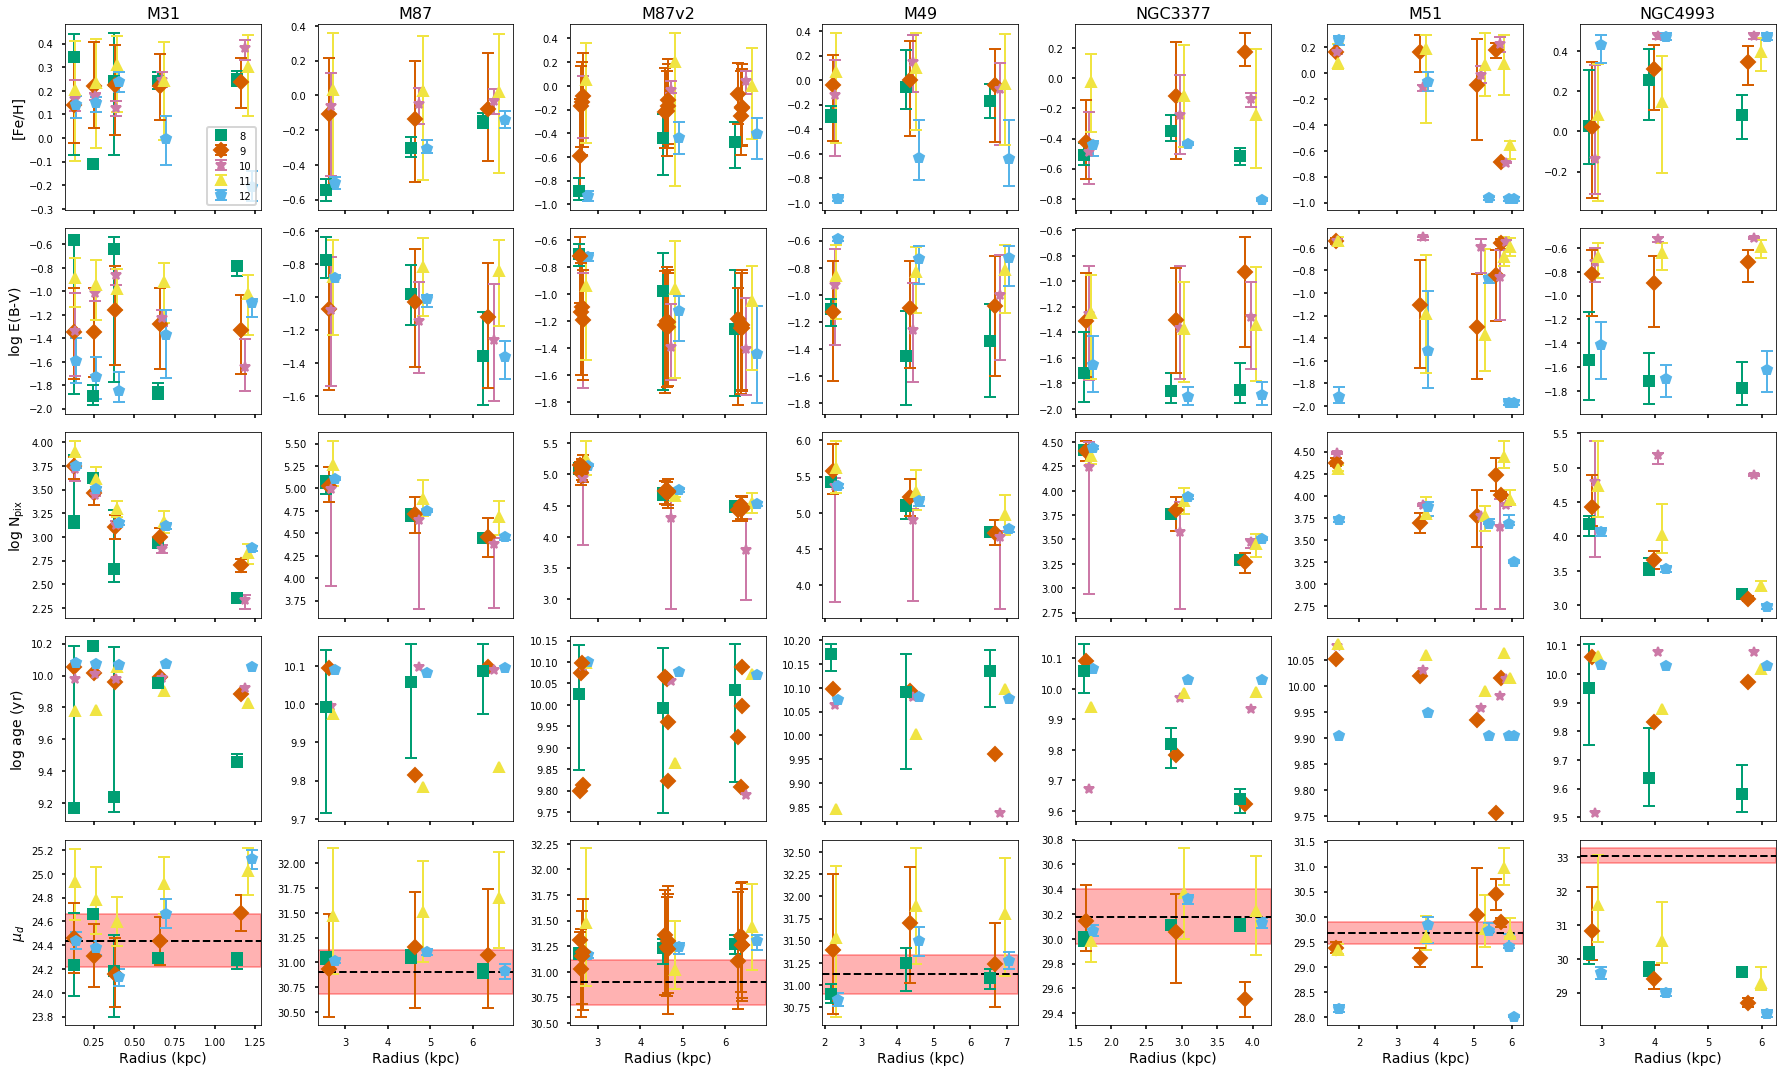

In [24]:
fig, axes = plt.subplots(ncols=7, nrows=5, figsize=(25, 15), sharex='col', sharey=False)
# for a in axes[-1]:
#     a._shared_y_axes.remove(a)
for i, g in enumerate(tqdm(['M31', 'M87', 'M87v2', 'M49', 'NGC3377', 'M51', 'NGC4993'])):
    a = axes[:, i]
    if g in ['M31', 'M51']:
        rs = ['a','b','c','d','e']
    else:
        rs = ['a1', 'b1', 'c1', 'a2','b2','c2','a3','b3','c3','a4','b4','c4']
    for j, r in enumerate(rs):
        for q, m in enumerate([7,8,9,10,11,12]):
            if m in [7, 9, 11]:
                the_axes = [a[0], a[1], None, None, None, None, None, a[2], a[4]]
            elif m in [8]:
                the_axes = a
            elif m in [10]:
                the_axes = [a[0], a[1], None, None, None, None, None, a[2]]
            elif m in [12]:
                the_axes = [a[0], a[1], a[2], None, a[4]]
            k = f'{g}_{r}_m{m}'
            marker = markers[q]
            color = colors[q]
            if k in results:
                x = radii_kpc[k] * (1.0 + ((q-2.5)*0.02))
                results[k].plot_errorbars(the_axes, x=x, color=color, marker=marker, label=(m if j==0 else None))
                if m not in [8]:
                    a[3].plot(x, results[k].best_model.sfh_model.mean_age, color=color, marker=marker, ms=10)
    a[-1].axhline(y=dmods[g], ls='--', color='k')
    a[-1].axhspan(dmods[g]-0.22, dmods[g]+0.22, color='r', alpha=0.3)
    a[0].set_title(g)
axes[0,0].legend(loc=0, fontsize=10)
for a in axes[-1]:
    a.set_xlabel('Radius (kpc)')
for i, a in enumerate(axes[:,0]):
    a.set_ylabel(results['M87v2_a1_m8'].labels[i])
fig.tight_layout()

## Status of Jobs

In [15]:
for m in [8,9,10,11,12]:
    print(f'\nModel{m}')
    for g in ['M87v2', 'M87', 'M31', 'NGC3377', 'NGC4993']:
        n_total = len([k for k in results.keys() if g in k and f'_m{m}' in k])
        n_done = len([k for k in pcmds.keys() if g in k and f'_m{m}' in k])
        print(g, f'{n_done} of {n_total}')
        for k in [k for k in results.keys() if g in k and f'_m{m}' in k]:
            if k in pcmds:
                print('', k, 'dLogz: ', '{:.2e}'.format(results[k].as_dynesty()['delta_logz'][-1]))
            else:
                print('', k, '-- Still Running')


Model8
M87v2 3 of 3
 M87v2_a1_m8 dLogz:  8.95e-03
 M87v2_b1_m8 dLogz:  6.00e-03
 M87v2_c1_m8 dLogz:  1.65e-03
M87 6 of 6
 M87_a1_m8 dLogz:  5.59e-03
 M87_b1_m8 dLogz:  1.61e-02
 M87_c1_m8 dLogz:  3.58e-04
 M87v2_a1_m8 dLogz:  8.95e-03
 M87v2_b1_m8 dLogz:  6.00e-03
 M87v2_c1_m8 dLogz:  1.65e-03
M31 5 of 5
 M31_e_m8 dLogz:  1.74e-06
 M31_d_m8 dLogz:  1.02e-07
 M31_c_m8 dLogz:  1.10e+00
 M31_b_m8 dLogz:  2.79e-06
 M31_a_m8 dLogz:  6.93e-01
NGC3377 3 of 3
 NGC3377_a1_m8 dLogz:  4.61e-03
 NGC3377_b1_m8 dLogz:  1.04e-02
 NGC3377_c1_m8 dLogz:  4.00e-03
NGC4993 3 of 3
 NGC4993_a1_m8 dLogz:  8.26e-05
 NGC4993_b1_m8 dLogz:  2.68e-05
 NGC4993_c1_m8 dLogz:  2.75e-05

Model9
M87v2 10 of 12
 M87v2_a1_m9 dLogz:  1.10e+00
 M87v2_a2_m9 -- Still Running
 M87v2_a3_m9 dLogz:  6.39e-01
 M87v2_a4_m9 dLogz:  8.00e-01
 M87v2_b1_m9 dLogz:  6.78e-01
 M87v2_b2_m9 dLogz:  1.10e+00
 M87v2_b3_m9 dLogz:  2.58e+00
 M87v2_b4_m9 dLogz:  1.58e+00
 M87v2_c1_m9 dLogz:  3.04e-01
 M87v2_c2_m9 -- Still Running
 M87v2_c3_m9 

# Residual Plots

## M31

Modeling best fit for M31_e_m10


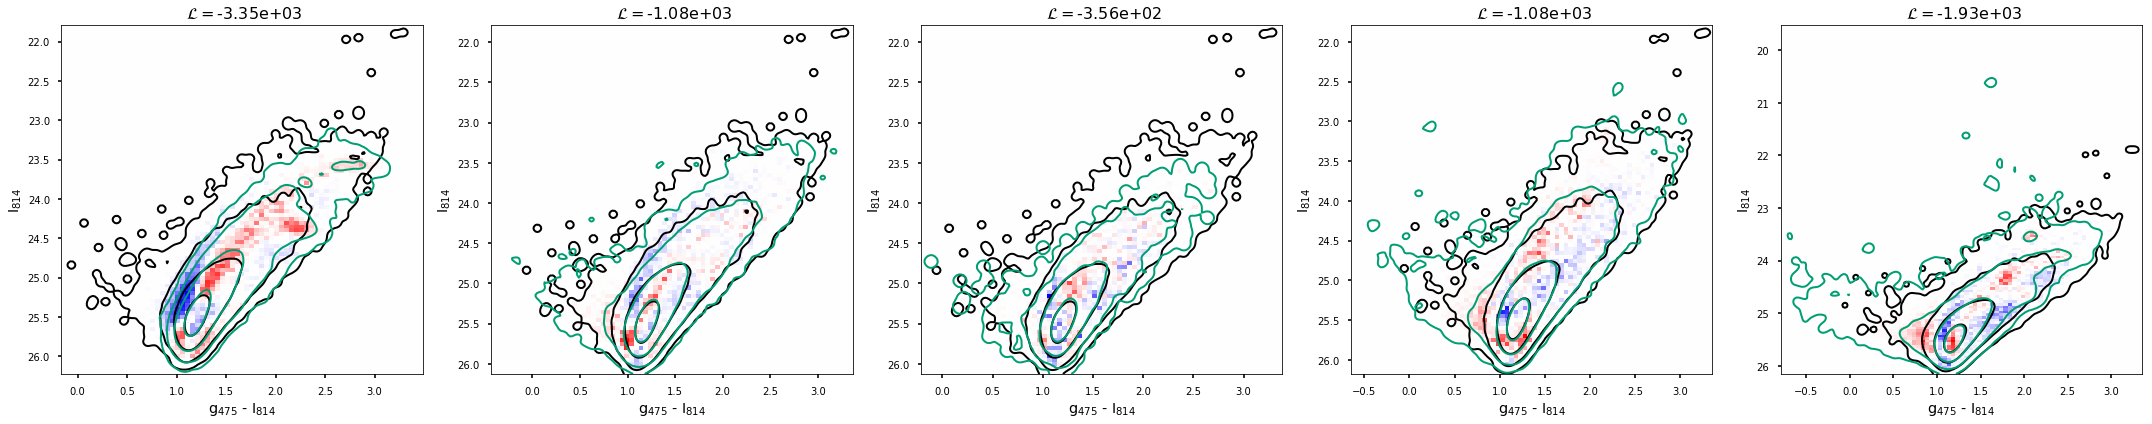

In [42]:
many_residuals([f'M31_e_m{m}' for m in [8,9,10,11,12]], residuals=True, force_resim=False);

Modeling best fit for NGC3377_c1_m9


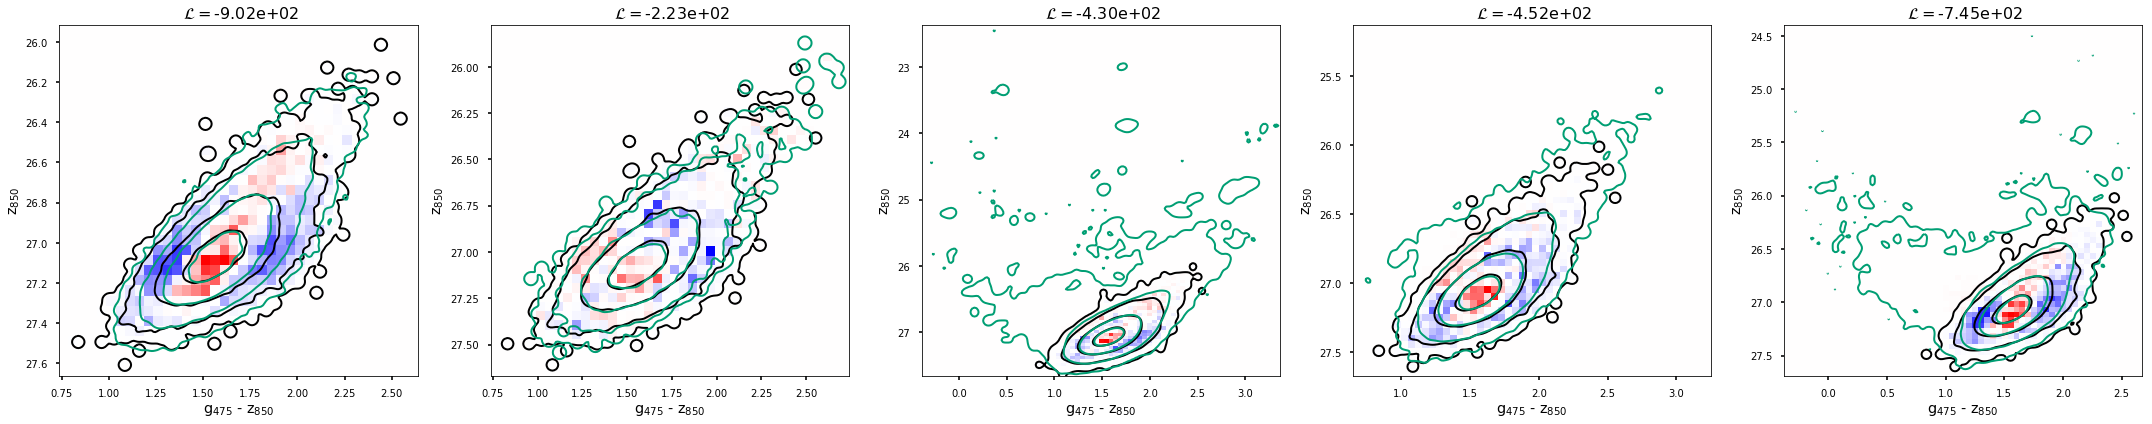

In [43]:
many_residuals([f'NGC3377_c1_m{m}' for m in [8,9,10,11,12]], residuals=True, force_resim=False);

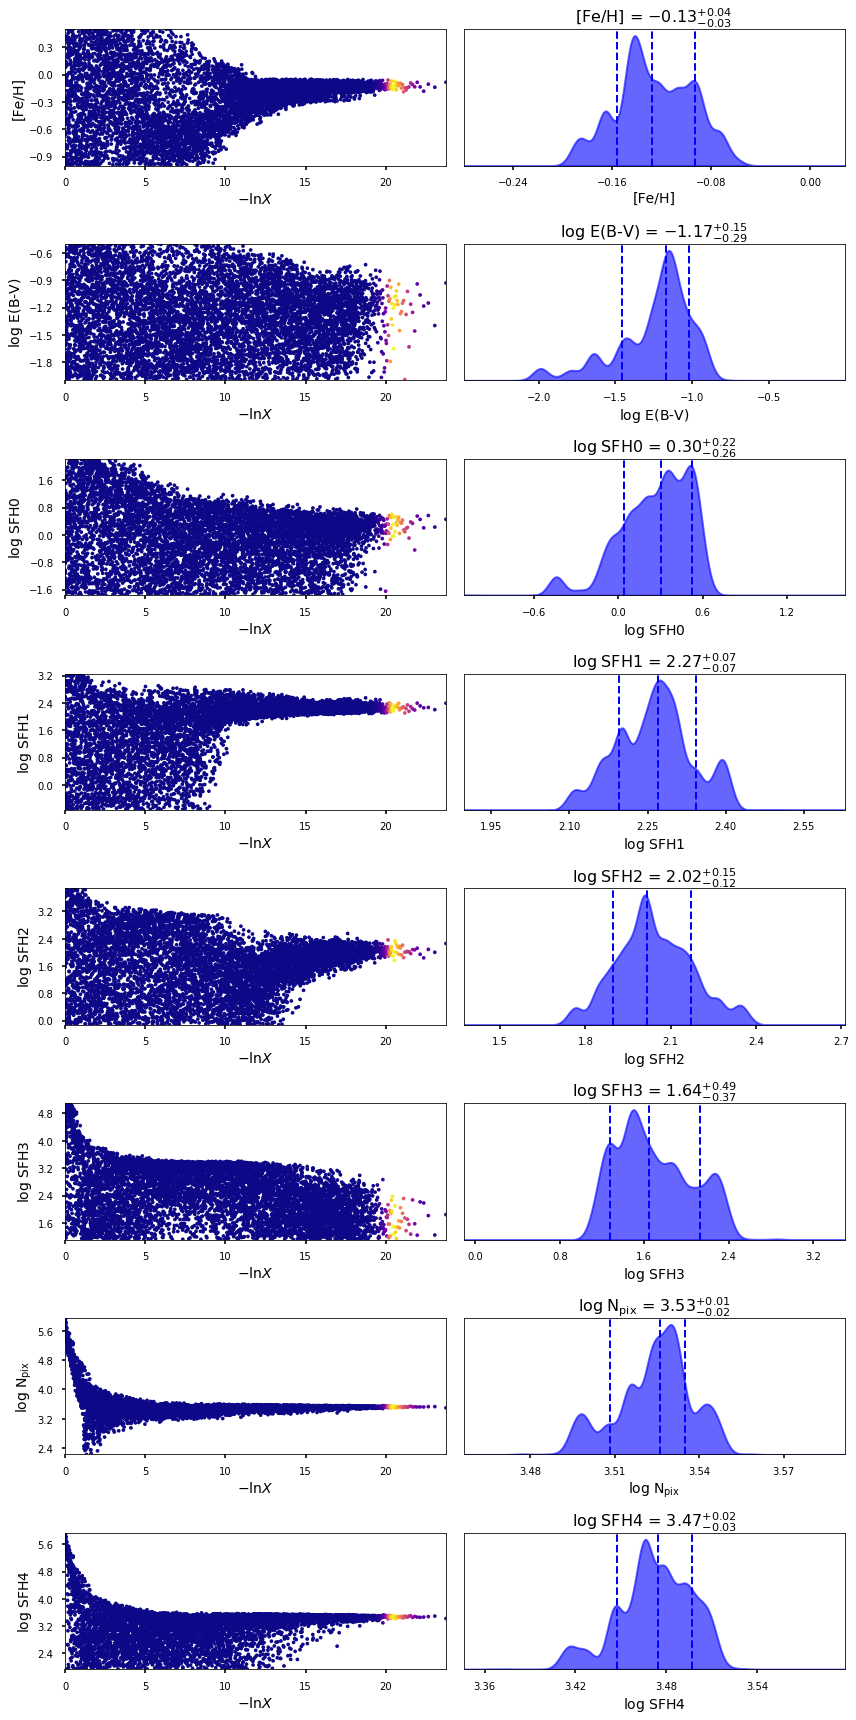

In [44]:
results['NGC3377_c1_m10'].plot_trace();

Modeling best fit for M31_a_m8


NameError: name 'drivers' is not defined

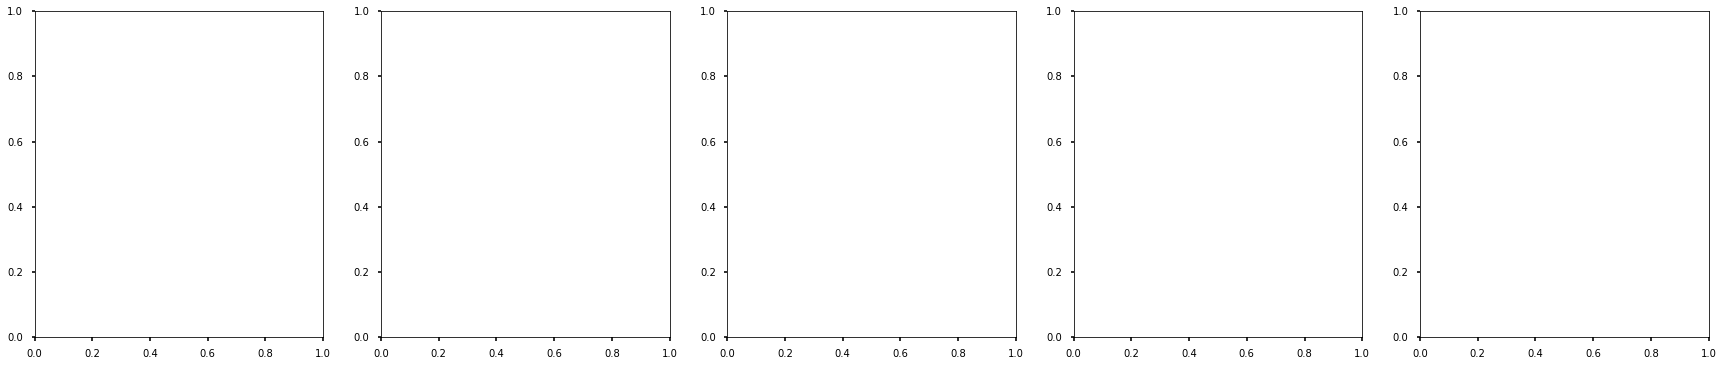

In [30]:
many_residuals([f'M31_{r}_m8' for r in ['a','b','c','d','e']], residuals=True, force_resim=False);

Modeling best fit for M31_a_m9


NameError: name 'drivers' is not defined

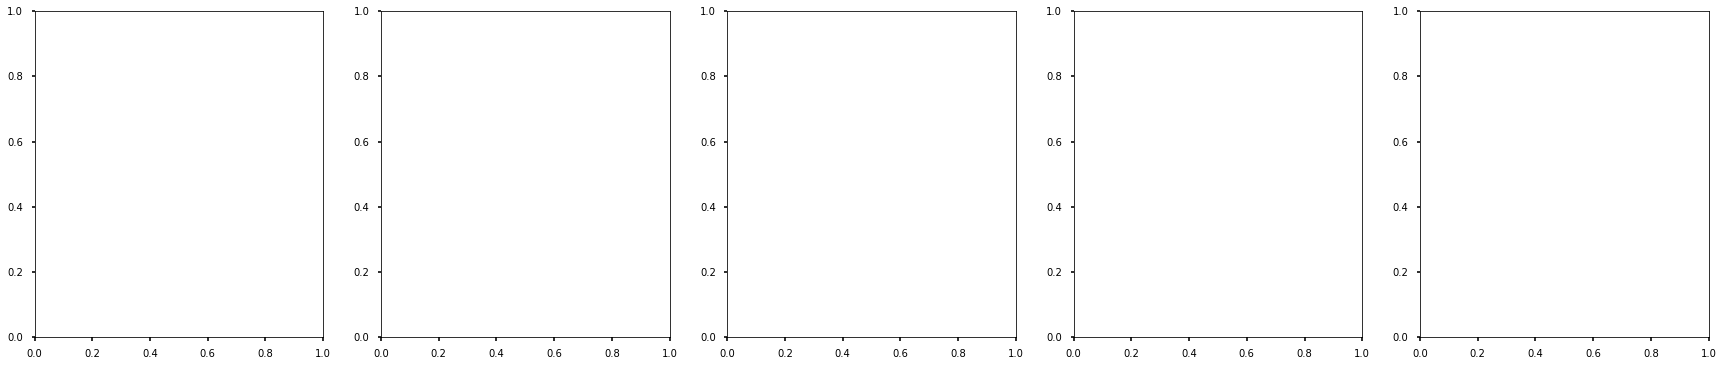

In [20]:
many_residuals([f'M31_{r}_m9' for r in ['a','b','c','d','e']], residuals=True, force_resim=True);

Modeling best fit for M31_a_m10
Modeling best fit for M31_b_m10
Modeling best fit for M31_c_m10
Modeling best fit for M31_d_m10
Modeling best fit for M31_e_m10


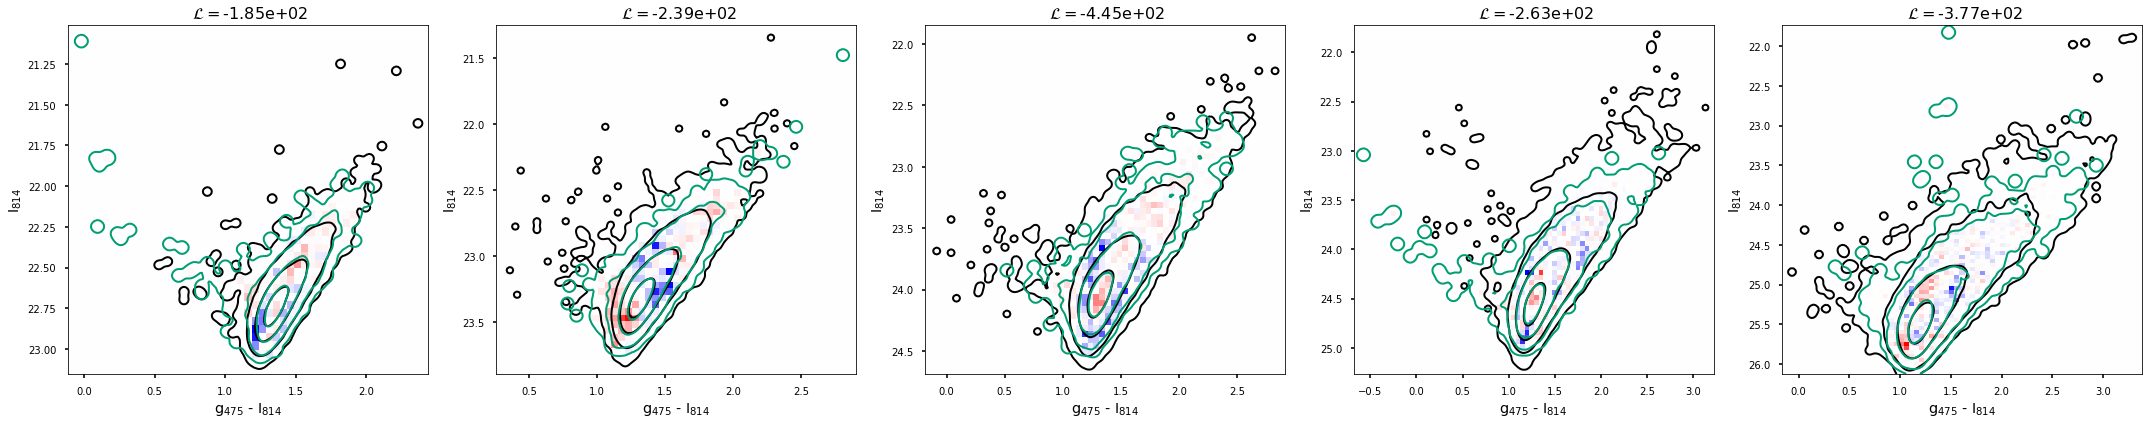

In [12]:
many_residuals([f'M31_{r}_m10' for r in ['a','b','c','d','e']], residuals=True, force_resim=True);

In [ ]:
many_residuals([f'NGC3377_{r}_m9' for r in ['a1', 'b1', 'c1']], residuals=True, force_resim=True);

Modeling best fit for NGC3377_c1_m8
Modeling best fit for NGC3377_c1_m9
Modeling best fit for NGC3377_c1_m10
Modeling best fit for NGC3377_c1_m12


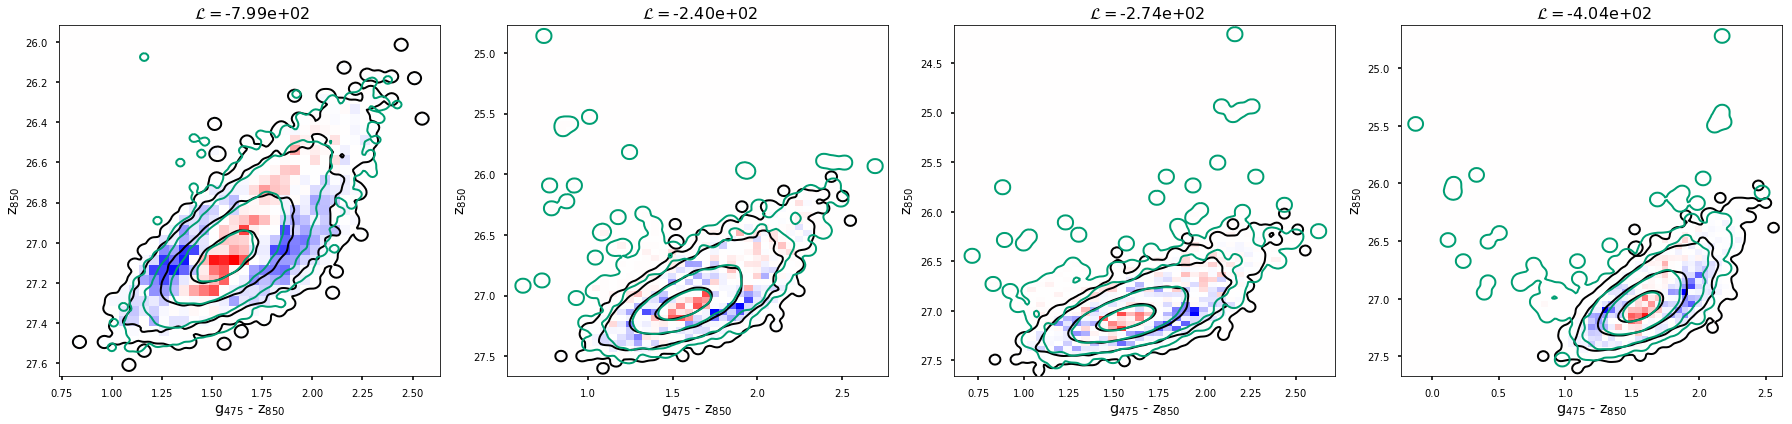

In [20]:
many_residuals([f'NGC3377_c1_m{m}' for m in [8, 9, 10, 12]], residuals=True, force_resim=True);

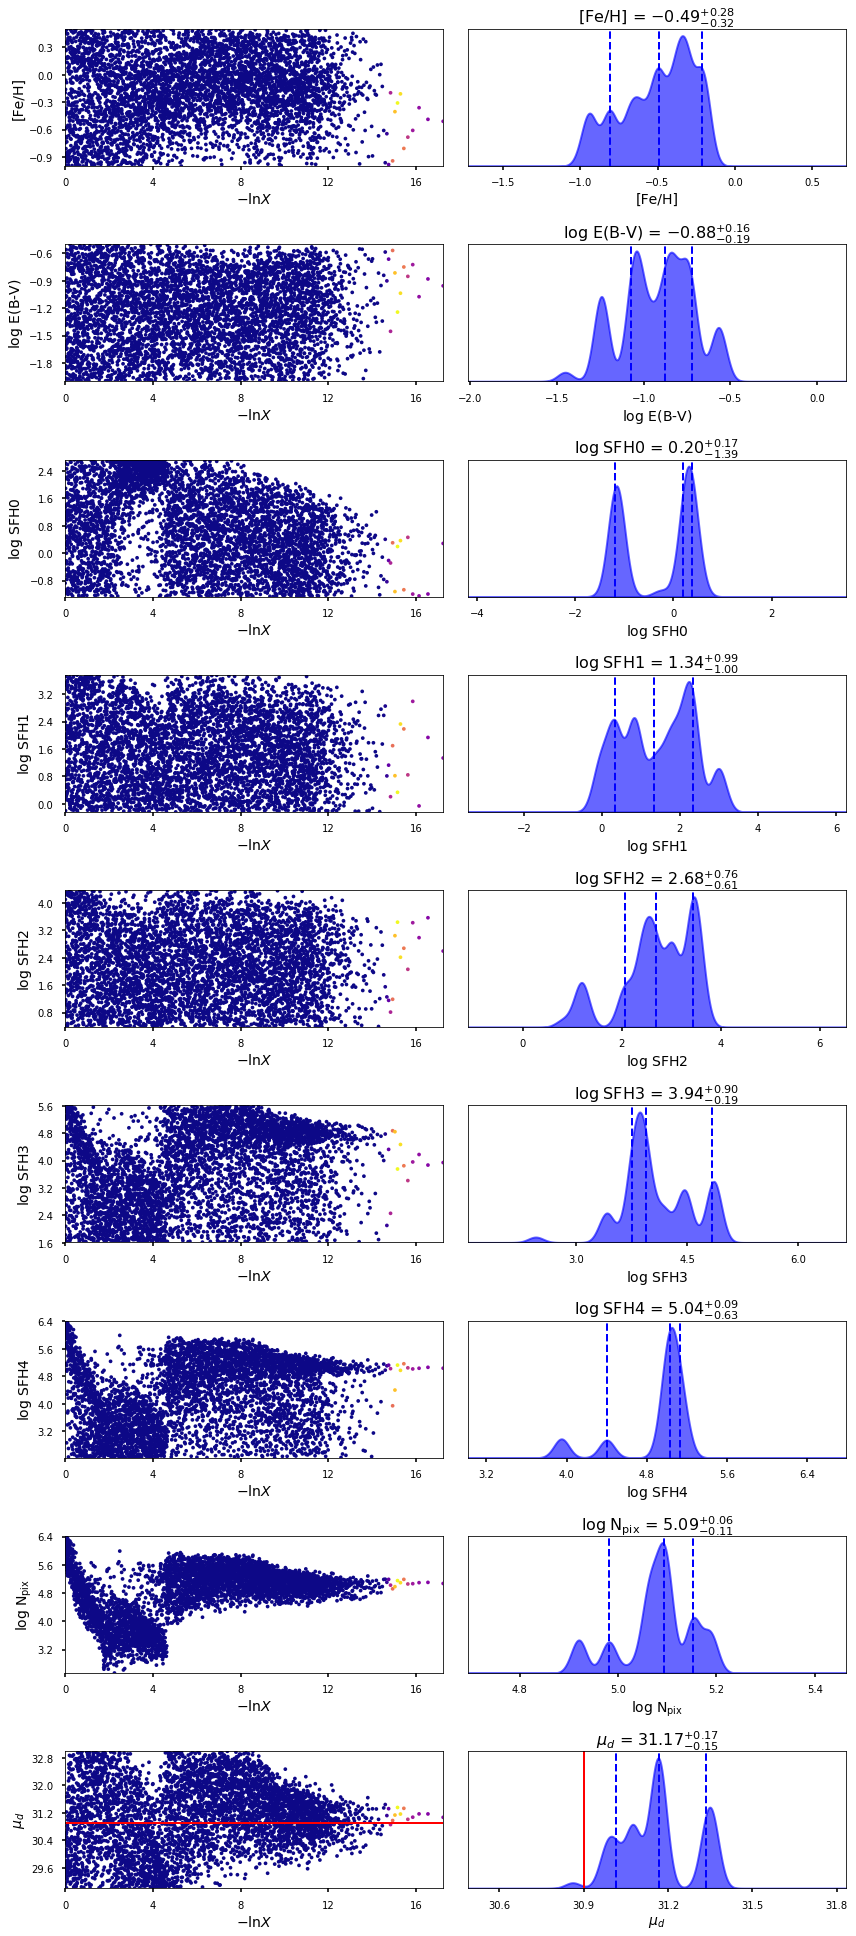

In [21]:
results['M87v2_a1_m9'].plot_trace();